In [1]:
import os
import pandas as pd

# Path to my dataset
path = 'dataset'

# Initialize lists for file paths and labels
file_paths = []
labels = []

# Traverse the dataset directory
for label in os.listdir(path):
    label_path = os.path.join(path, label)
    if os.path.isdir(label_path):  
        for file in os.listdir(label_path):
            if file.endswith('.jpg'):  
                file_paths.append(os.path.join(label_path, file))
                labels.append(label)

# Create a DataFrame
data = pd.DataFrame({
    'File_Path': file_paths,
    'Labels': labels
})

# Shuffle the dataset, fixed seed to 9
data = data.sample(frac=1, random_state=9).reset_index(drop=True)

# Display the first few rows to verify
data.head()

,File_Path,Labels
0,dataset\snow\0943.jpg,snow
1,dataset\lightning\1919.jpg,lightning
2,dataset\glaze\6574.jpg,glaze
3,dataset\hail\0479.jpg,hail
4,dataset\rime\5705.jpg,rime


In [2]:
# Count the number of images for each label
class_counts = data['Labels'].value_counts()

# Convert to a DataFrame for better presentation
class_counts_table = pd.DataFrame({
    'Classes': class_counts.index,
    'Number of Images': class_counts.values
})

# Display the table
print(class_counts_table)

      Classes  Number of Images
0        rime              1160
1     fogsmog               851
2         dew               698
3   sandstorm               692
4       glaze               639
5        snow               621
6        hail               591
7        rain               526
8       frost               475
9   lightning               377
10    rainbow               232


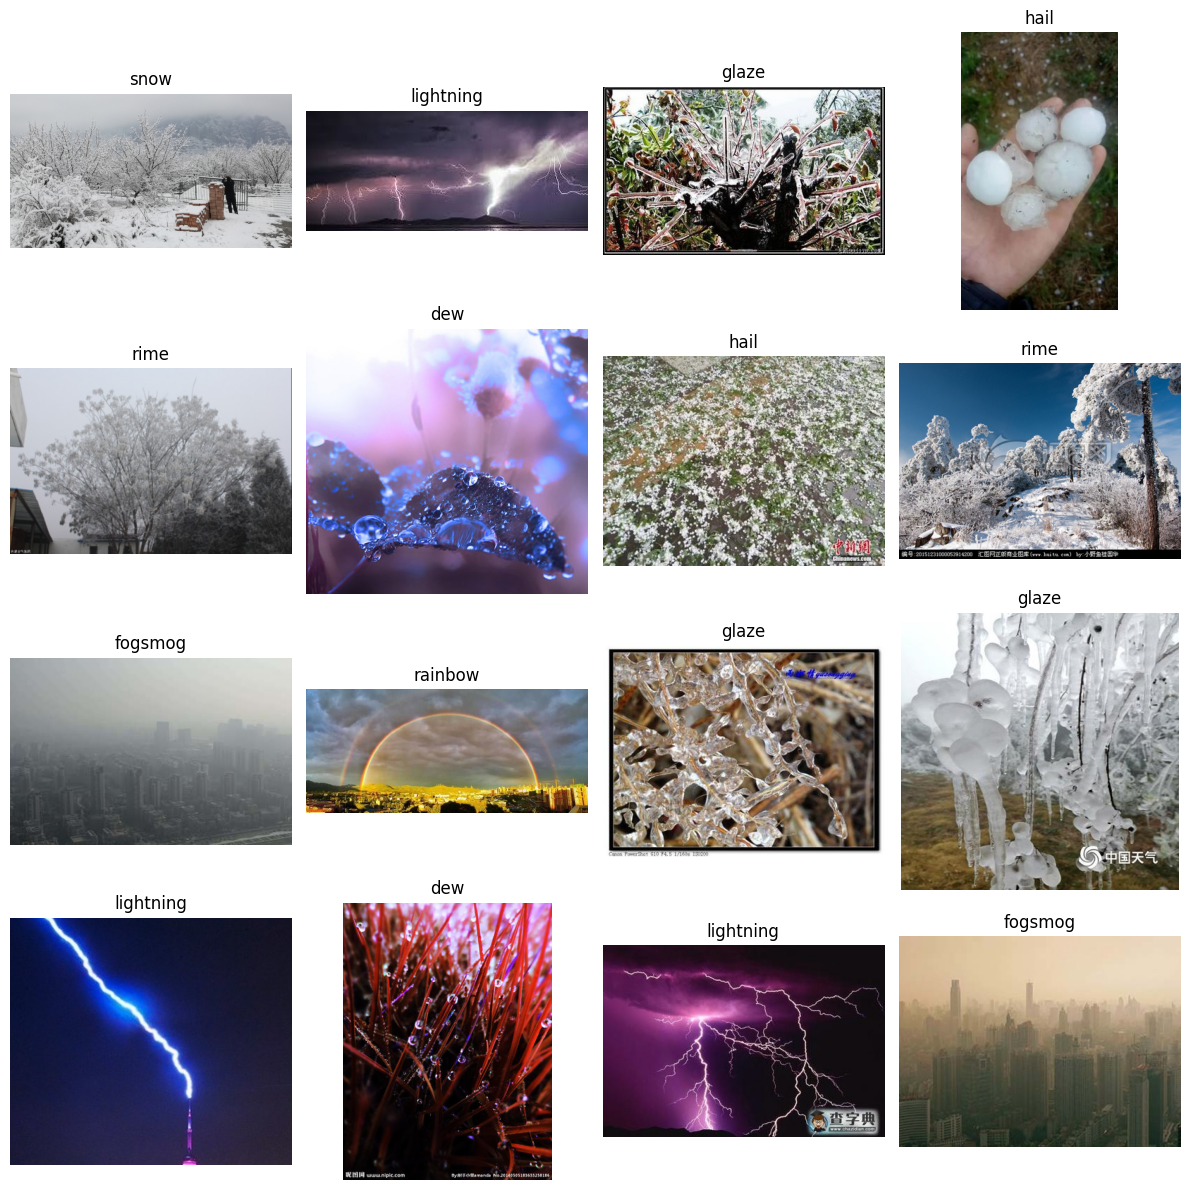

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display a 4x4 grid of images with labels
def plot_images(data, num_images=16):
    # Select the first 'num_images' rows of the dataset
    sample_data = data.iloc[:num_images]
    
    # Set up a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    # Flatten the axes array for easy iteration
    axes = axes.ravel()  

    for idx, ax in enumerate(axes):
        if idx < len(sample_data):
            # Read the image file
            img = mpimg.imread(sample_data.iloc[idx]['File_Path'])
            label = sample_data.iloc[idx]['Labels']
            
            # Display the image
            ax.imshow(img)
            # Set the label as the title
            ax.set_title(label)  
            # Turn off axes for a cleaner look
            ax.axis('off')       
        else:
            # Turn off unused axes
            ax.axis('off')  

    plt.tight_layout()
    plt.show()

# Call the function to display images and labels
plot_images(data)

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset: 80% training, 20% testing
train_df, test_df = train_test_split(data, test_size=0.2, random_state=123, stratify=data['Labels'])

# Display the sizes of the splits
print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 5489
Testing set size: 1373


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(preprocessing_fn, train_df, test_df, img_size=(100, 100), batch_size=32):
    """
    Create data generators for training, validation, and testing.

    Args:
        preprocessing_fn: Function for preprocessing (e.g., normalization, scaling).
        train_df: DataFrame containing training data paths and labels.
        test_df: DataFrame containing testing data paths and labels.
        img_size: Tuple indicating target image size (default: (100, 100)).
        batch_size: Number of images per batch (default: 32).

    Returns:
        train_generator: Generator for training data.
        validation_generator: Generator for validation data.
        test_generator: Generator for testing data.
    """
    # Define data augmentation for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_fn,
        validation_split=0.2,   # Reserve 20% of training data for validation
        rotation_range=25,      # Randomly rotate images
        width_shift_range=0.2,  # Randomly shift horizontally
        height_shift_range=0.2, # Randomly shift vertically
        shear_range=0.2,        # Randomly shear images
        zoom_range=0.2,         # Randomly zoom in/out
        horizontal_flip=True,   # Flip images horizontally
        fill_mode='nearest'     # Fill missing pixels after transformations
    )

    # Define test generator (no data augmentation)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_fn)

    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  
        shuffle=True,       
        seed=42
    )

    # Validation generator
    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',  
        shuffle=False,       
        seed=42
    )

    # Test generator
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False       
    )

    return train_generator, validation_generator, test_generator

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def create_model(base_model_func, num_classes=11, img_size=(100, 100)):
    """
    Function to create a model based on a pre-trained base model.

    Args:
        base_model_func: Function to load the pre-trained model (e.g., ResNet50).
        num_classes: Number of output classes (default 11).
        img_size: Size of input image (default 100x100).

    Returns:
        model: Compiled Keras model.
        callbacks: List of callbacks to be used during training.
    """
    # Load pre-trained model without the top layer (use 'include_top=False')
    base_model = base_model_func(input_shape=(img_size[0], img_size[1], 3),
                                  include_top=False,
                                  weights='imagenet',
                                  pooling='avg')
    
    # Freeze the base model (do not train its weights)
    base_model.trainable = False

    # Input layer for custom model
    input_layer = base_model.input
    
    # Add custom dense layers
    x = Dense(100, activation='relu')(base_model.output)  # First custom layer
    x = Dense(100, activation='relu')(x)                   # Second custom layer
    output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation
    
    # Create the final model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with categorical crossentropy loss and Adam optimizer
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up early stopping callback to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=3,        # Patience is adjusted here
                                   restore_best_weights=True)
    
    # Return the model and the list of callbacks
    return model, [early_stopping]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(training_history, test_generator, train_generator, model, test_data_frame):
    # Plotting Accuracy and Loss curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes = axes.ravel()

    for idx, metric in enumerate(['accuracy', 'loss']):
        axes[idx].plot(training_history.history[metric], label='Training ' + metric)
        axes[idx].plot(training_history.history['val_' + metric], label='Validation ' + metric)
        axes[idx].set_title(f'Model {metric.capitalize()}')
        axes[idx].set_xlabel('Epochs')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Predicting on the test set
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Mapping the class indices back to labels
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_labels = [class_labels[class_idx] for class_idx in predicted_classes]

    # Display confusion matrix and classification report
    true_labels = test_data_frame['Labels']
    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_labels.values())
    print("Classification Report:\n", report)

    # Plotting the confusion matrix with seaborn for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Displaying sample images with true and predicted labels
    fig, axes = plt.subplots(3, 3, figsize=(12, 9))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < len(test_data_frame):  # Ensures no index out-of-range errors
            img_path = test_data_frame['File_Path'].iloc[i]
            img = plt.imread(img_path)
            true_label = test_data_frame['Labels'].iloc[i]
            pred_label = predicted_labels[i]

            ax.imshow(img)
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Leave remaining subplots blank

    plt.tight_layout()
    plt.show()

    return training_history

In [8]:
def evaluate_results(test_generator, model):
    # Evaluate the model on the test data
    evaluation_results = model.evaluate(test_generator, verbose=0)

    # Display the results
    print(f"Test Dataset Evaluation:")
    print(f"   Loss: {evaluation_results[0]:.5f}")
    print(f"   Accuracy: {evaluation_results[1] * 100:.2f}%")

    return evaluation_results

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.


c:\Users\jchen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


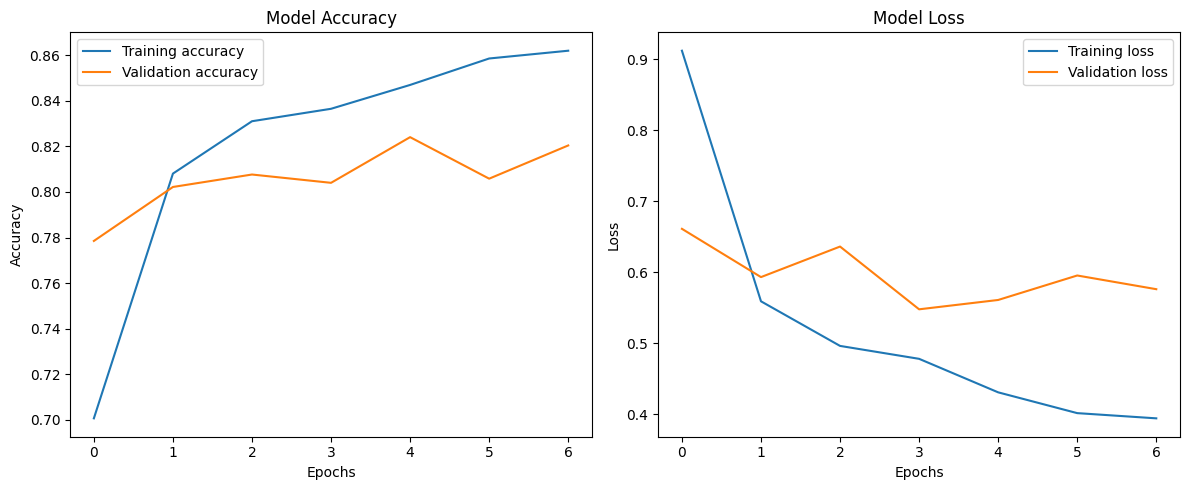

43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 729ms/step
Classification Report:
               precision    recall  f1-score   support

         dew       0.88      0.89      0.89       140
     fogsmog       0.90      0.87      0.88       170
       frost       0.76      0.58      0.66        95
       glaze       0.68      0.55      0.61       128
        hail       0.93      0.91      0.92       118
   lightning       0.87      0.93      0.90        76
        rain       0.94      0.65      0.77       105
     rainbow       0.93      0.93      0.93        46
        rime       0.71      0.91      0.80       232
   sandstorm       0.93      0.84      0.88       139
        snow       0.61      0.76      0.67       124

    accuracy                           0.81      1373
   macro avg       0.83      0.80      0.81      1373
weighted avg       0.82      0.81      0.81      1373



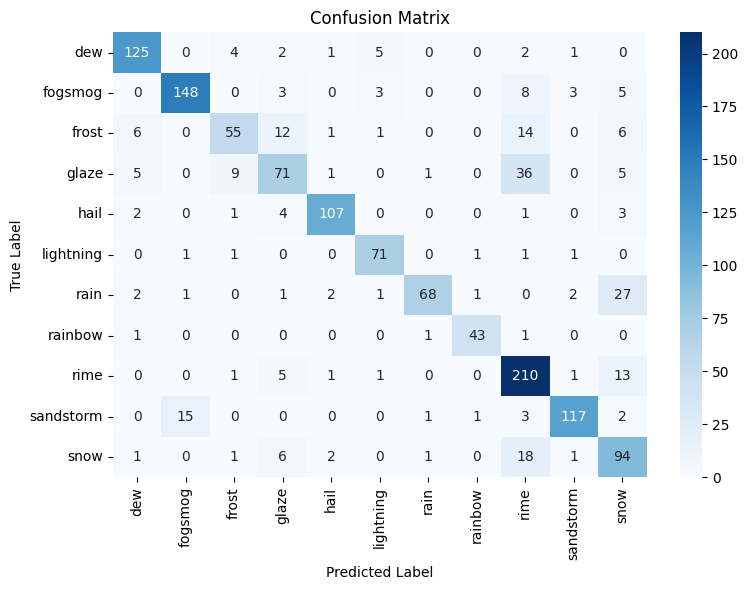

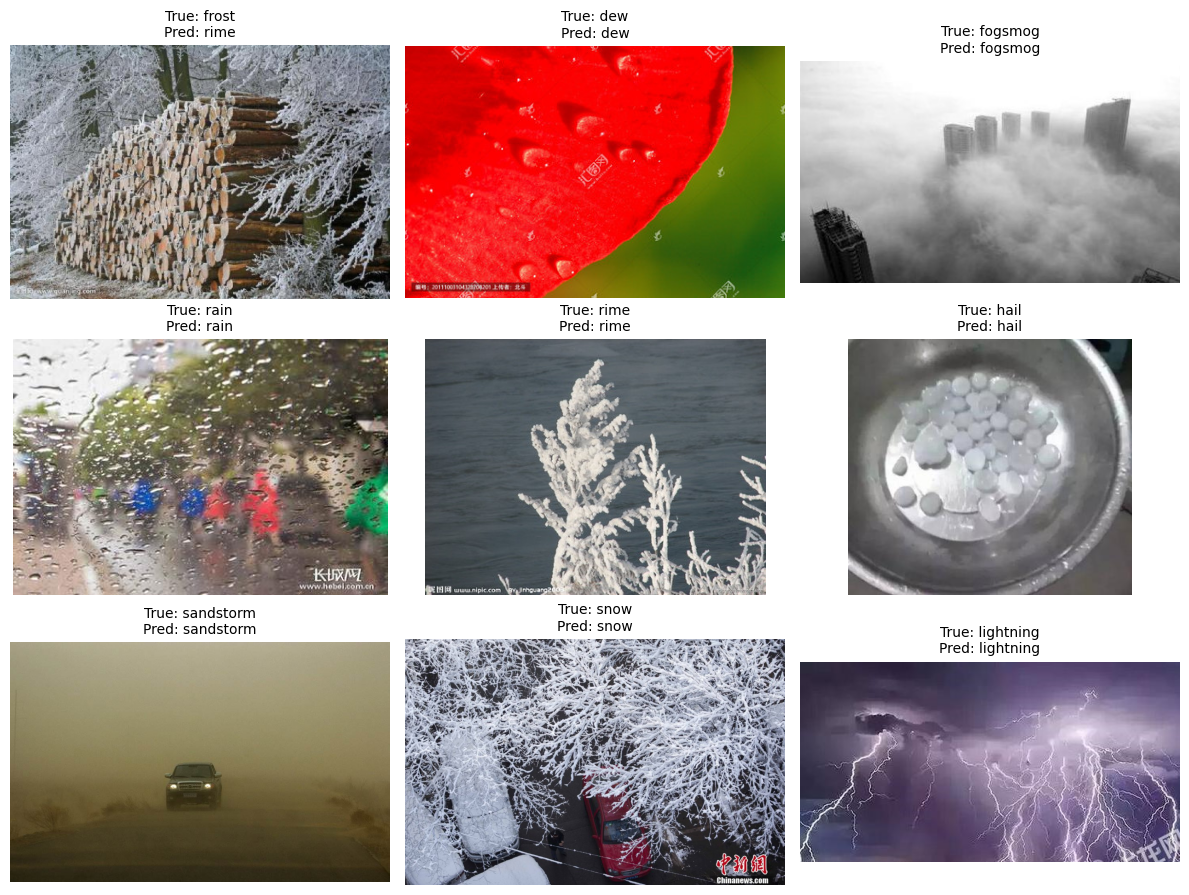

Test Dataset Evaluation:
   Loss: 0.56599
   Accuracy: 80.77%


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Preprocessing function for ResNet50
ResNet_preprocessing = preprocess_input

# Generate data for training, validation, and testing
train_generators, valid_generators, test_generators = create_generators(ResNet_preprocessing, train_df, test_df)

# Create ResNet50 model and configure callbacks
ResNet_model, callback = create_model(ResNet50)

# Train the ResNet50 model
history = ResNet_model.fit(
    train_generators,
    validation_data=valid_generators,
    epochs=100,
    callbacks=callback,
    verbose=0
)

# Evaluate the model and visualize performance
history_analysis = evaluate_model(history, test_generators, train_generators, ResNet_model, test_df)

# Test results on the test dataset
test_result = evaluate_results(test_generators, ResNet_model)